In [25]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit_ibm_provider import IBMProvider, least_busy
import os
from dotenv import load_dotenv
import pylatexenc

load_dotenv()

False

This is a general $n$-bit diffuser defined by Qiskit in https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm

In [42]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

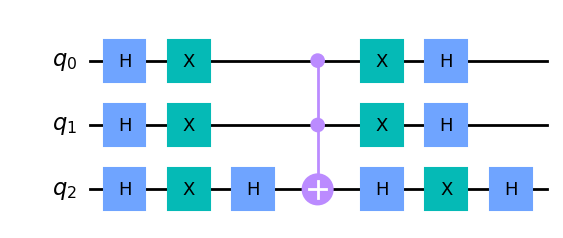

In [43]:
ex_qc = QuantumCircuit(3)
for qubit in range(3):
    ex_qc.h(qubit)
# Apply transformation |00..0> -> |11..1> (X-gates)
for qubit in range(3):
    ex_qc.x(qubit)
# Do multi-controlled-Z gate
ex_qc.h(3-1)
ex_qc.mct(list(range(3-1)), 3-1)  # multi-controlled-toffoli
ex_qc.h(3-1)
# Apply transformation |11..1> -> |00..0>
for qubit in range(3):
    ex_qc.x(qubit)
# Apply transformation |00..0> -> |s>
for qubit in range(3):
    ex_qc.h(qubit)

ex_qc.draw(output='mpl', fold=-1)

We will be looking at the following 3-SAT of 5 clauses
$$
(\neg{v_1} \lor \neg{v_2} \lor \neg{v_3}) \land (v_1 \lor \neg{v_2} \lor v_3) \land (v_1 \lor v_2 \lor \neg{v_3}) \land (v_1 \lor \neg{v_2} \lor \neg{v_3}) \land (\neg{v_1} \lor v_2 \lor v_3)
$$
with solution set expressed as $(v_1, v_2, v_3)$
$$
(T, F, T) = 101\\
(F, F, F) = 000 \\
(T, T, F) = 110 \\
$$

First we define our quantum OR, which simulates an OR by flipping all inputs and performing a multi-qubit AND (Toffoli/CCNOT gate) on the output qubit (then flipping back to preserve the original inputs). The output qubit should be initially 1 for it to output the correct answer. You can view/interact with this circuit [here](https://algassert.com/quirk#circuit={%22cols%22:[[%22~sb6e%22,%22~tigb%22,%22~k19d%22,%22~gt47%22],[%22X%22,%22X%22,%22X%22],[%22%E2%80%A2%22,%22%E2%80%A2%22,%22%E2%80%A2%22,%22X%22],[%22X%22,%22X%22,%22X%22]],%22gates%22:[{%22id%22:%22~sb6e%22,%22name%22:%22a%22,%22matrix%22:%22{{1,0},{0,1}}%22},{%22id%22:%22~tigb%22,%22name%22:%22b%22,%22matrix%22:%22{{1,0},{0,1}}%22},{%22id%22:%22~k19d%22,%22name%22:%22c%22,%22matrix%22:%22{{1,0},{0,1}}%22},{%22id%22:%22~gt47%22,%22name%22:%22out%22,%22matrix%22:%22{{1,0},{0,1}}%22}],%22init%22:[0,0,0,1]}).

In [27]:
# Define quantum OR
def OR(qc, vars, out):
    # Invert all inputs
    qc.x(vars[0])
    qc.x(vars[1])
    qc.x(vars[2])

    # Compute AND
    qc.mct(vars, out)

    # Flip back to original inputs
    qc.x(vars[0])
    qc.x(vars[1])
    qc.x(vars[2])

Next we define a function to add a clause to from the 3-SAT statement to our circuit. Since all clauses consist of (intact or negated) variables in an OR, we negate variables with an X gate where applicable, and apply our previously mentioned OR gate. Negated variables are defined in the `clause` parameter, where a negative number means the given variable is negated.

In [36]:
def add_clause(qc, clause, var_qubits, clause_qubit):
    # Flip the clause statement because qiskit orders qubits in reverse
    clause = clause[::-1]

    # Apply NOT gates to all variables that are negated in this clause
    for i in range(len(clause)):
        if clause[i] < 0:
            qc.x(var_qubits[i])

    # Apply OR flipper
    OR(qc, var_qubits, clause_qubit)

    # Uncompute NOT gates
    for i in range(len(clause)):
        if clause[i] < 0:
            qc.x(var_qubits[i])

    

Finally, we initialize our circuit and add the clauses.

In [37]:
# Initialize circuit
var_qubits = QuantumRegister(3, name='v')    # One qubit per variable
clause_qubits = QuantumRegister(5, name='c') # One cubit per clause
out_qubit = QuantumRegister(1, name='out')   # Used to write output of clauses
cbits = ClassicalRegister(3, name='cbits')   # Three classical bits for output

qc = QuantumCircuit(var_qubits, clause_qubits, out_qubit, cbits)

# Initialize 'out' in state |->
qc.initialize([1, -1]/np.sqrt(2), out_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)

# Initialize clause qubits to 1
# The OR flipper will flip them to back 0/false if all the inputs are 0/false
qc.x(clause_qubits)

qc.barrier()  # for visual separation

In [38]:
# Add the first clause ( -v1 OR -v2 OR -v3 )
add_clause(qc, [-1, -1, -1], var_qubits, clause_qubits[0])

# Add second clause (v1 OR -v2 OR v3)
add_clause(qc, [1, -1, 1], var_qubits, clause_qubits[1])

# Add third clause (v1 OR v2 OR -v3)
add_clause(qc, [1, 1, -1], var_qubits, clause_qubits[2])

# Add fourth clause (v1 OR -v2 OR -v3)
add_clause(qc, [1, -1, -1], var_qubits, clause_qubits[3])

# Add fifth clause (-v1 OR v2 OR v3)
add_clause(qc, [-1, 1, 1], var_qubits, clause_qubits[4])

# Flip output if all clauses are satisfied
qc.mct(clause_qubits, out_qubit)

qc.barrier()

# Uncompute clauses to reset clause-checking bits to 0
add_clause(qc, [-1, -1, -1], var_qubits, clause_qubits[0])
add_clause(qc, [1, -1, 1], var_qubits, clause_qubits[1])
add_clause(qc, [1, 1, -1], var_qubits, clause_qubits[2])
add_clause(qc, [1, -1, -1], var_qubits, clause_qubits[3])
add_clause(qc, [-1, 1, 1], var_qubits, clause_qubits[4])




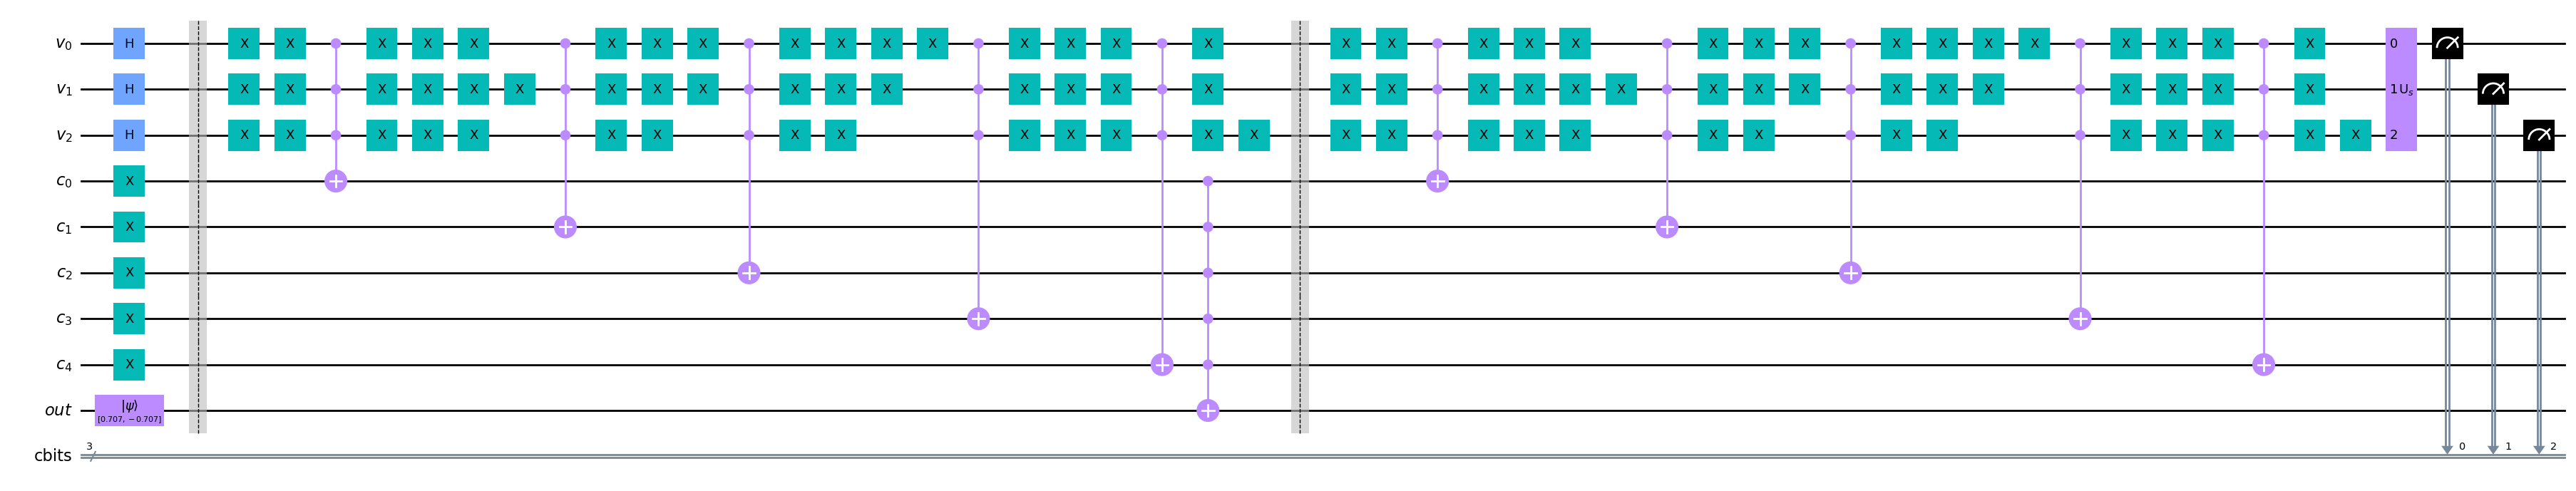

In [39]:
# Append diffuser
qc.append(diffuser(3), [0,1,2])

# Perform measurement
qc.measure(var_qubits, cbits)
qc.draw(output='mpl', fold=-1)

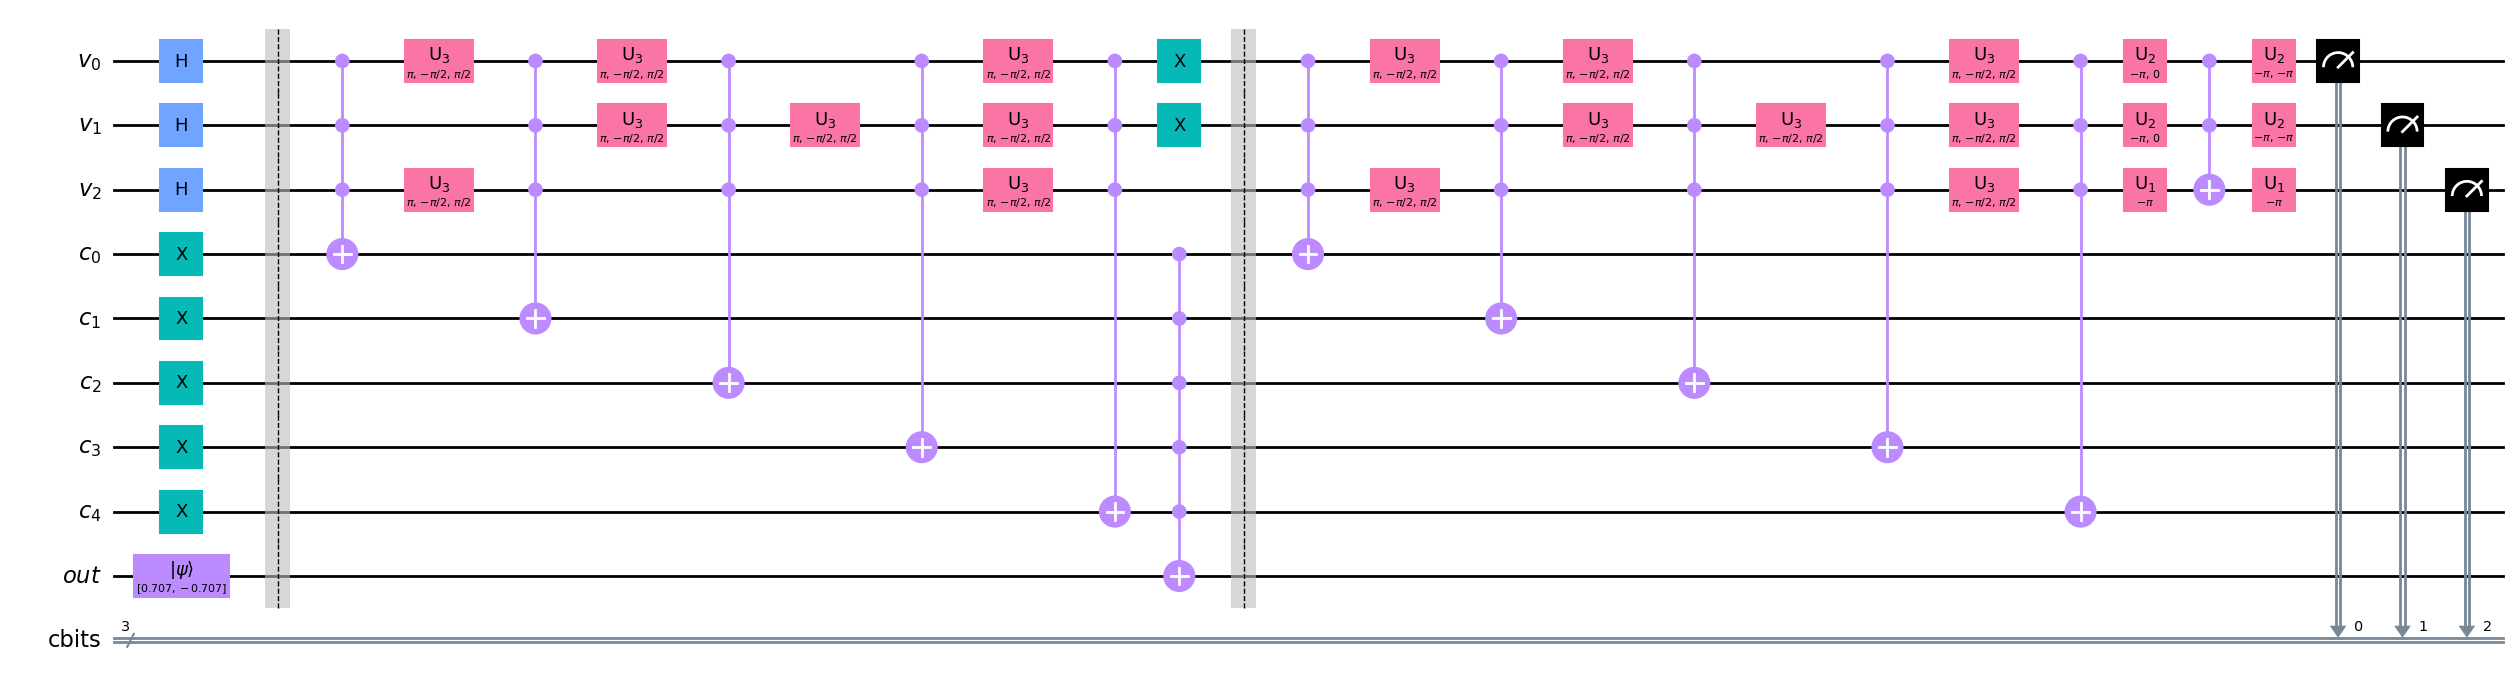

In [40]:
# Run on simulator
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
transpiled_qc.draw(output='mpl', fold=-1)

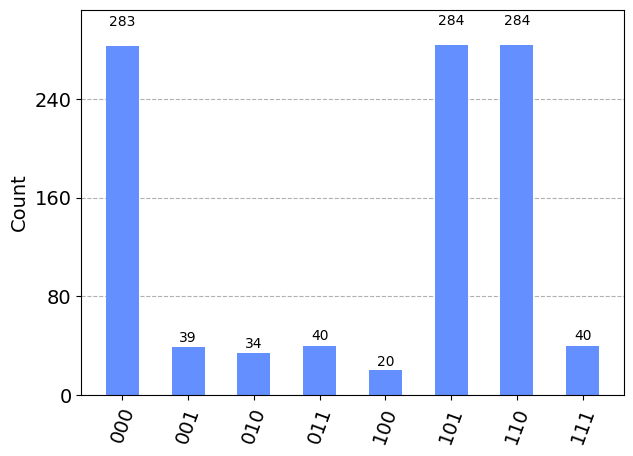

In [41]:
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

In [10]:
# Connect account to run on real device
provider = IBMProvider(token=os.getenv('IBMQ_API_TOKEN'))

In [15]:
print(provider.active_account())

# Select least busy available backend
filtered_backends = provider.backends(simulator=False, operational=True, min_num_qubits=qc.num_qubits)
least_busy_backend = least_busy(filtered_backends)

print(filtered_backends)
print(least_busy_backend)

{'channel': 'ibm_quantum', 'token': '02da94f84a31059b2dd31cb11eadc4b69124720b75693a0cf0e56bc1c37d2b0951069082b05220e64f0384a1dd906a354ba5891f1d4559df6ee85f9dbb7eae6d', 'url': 'https://auth.quantum-computing.ibm.com/api', 'verify': True, 'instance': 'ibm-q-ncsu/nc-state/csc591-ece592-fa'}
[<IBMBackend('ibm_algiers')>, <IBMBackend('ibm_cairo')>, <IBMBackend('ibm_brisbane')>]
<IBMBackend('ibm_algiers')>


In [16]:
device = provider.get_backend(least_busy_backend.name)

print(f"Backend: {device.name} v{device.backend_version}")
print(f"{device.num_qubits} qubits")
print(f"Pending jobs: {device.status().pending_jobs}")

Backend: ibm_algiers v1.6.16
27 qubits
Pending jobs: 71


In [21]:
transpiled_qc = transpile(qc, device, optimization_level=3)
transpiled_qc.draw(output='mpl', fold=-1)

/Users/kmsi/Development/CSC591/venvs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kmsi/Development/CSC591/venvs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kmsi/Development/CSC591/venvs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kmsi/Development/CSC591/venvs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kmsi/Development/CSC591/venvs/qiskit/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/U

In [ ]:

job = device.run(transpiled_qc)